In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm


#### Old code

In [ ]:

# ----- Encoder -----
class TaskEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.ff_layer = nn.Linear(2, embedding_dim)
        self.gru_encoder = nn.GRU(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)

    def forward(self, input_coords):
        embedded = self.ff_layer(input_coords)
        encoder_outputs, hidden = self.gru_encoder(embedded)
        return embedded, encoder_outputs, hidden

# ----- Attention -----
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.W2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs, mask):
        decoder_hidden = decoder_hidden.transpose(0, 1)  # (1, B, H) -> (B, 1, H)
        score = self.v(torch.tanh(self.W1(encoder_outputs) + self.W2(decoder_hidden)))  # (B, S, 1)
        score = score.squeeze(-1)
        score[mask == 0] = -1e9  # Mask visited
        attn_weights = F.softmax(score, dim=-1)
        return attn_weights

# ----- Decoder -----
class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.attention = Attention(hidden_dim)

    def forward(self, decoder_input, hidden, encoder_outputs, mask):
        output, hidden = self.gru(decoder_input, hidden)
        attn_weights = self.attention(hidden, encoder_outputs, mask)
        return attn_weights, hidden

# ----- Critic -----
class Critic(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, encoder_outputs):
        pooled = encoder_outputs.mean(dim=1)
        return self.fc(pooled).squeeze(-1)

# ----- Training -----

def train_drl_ac(embedding_dim, hidden_dim, seq_len, batch_size, lr, epochs, n_batches):
    torch.manual_seed(42)
    encoder = TaskEncoder(embedding_dim)
    decoder = Decoder(embedding_dim, hidden_dim)
    critic = Critic(hidden_dim)

    actor_optim = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
    critic_optim = optim.Adam(critic.parameters(), lr=lr)

    for _ in tqdm(range(n_batches)):
        input_coords = torch.rand(batch_size, seq_len, 2)
        _, encoder_outputs, encoder_hidden = encoder(input_coords)

        for epoch in range(epochs):
            total_reward = 0
            mask = torch.ones(batch_size, seq_len)
            decoder_input = torch.randn(batch_size, 1, embedding_dim)
            hidden = encoder_hidden
            log_probs = []
            tour = []

            for _ in range(seq_len):
                attn_weights, hidden = decoder(decoder_input, hidden, encoder_outputs, mask.clone())
                dist = torch.distributions.Categorical(attn_weights)
                selected = dist.sample()
                # selected = torch.argmax(attn_weights, dim=1)
                log_prob = dist.log_prob(selected)
                log_probs.append(log_prob.squeeze())
                idx = selected.item()
                tour.append(idx)
                mask = mask.clone()
                mask.scatter_(1, torch.tensor([[idx]]), 0)  # safe scatter op
                decoder_input = encoder_outputs[0, idx].detach().clone().unsqueeze(0).unsqueeze(1)

            coords = input_coords[0][tour]
            path = torch.cat([coords, coords[0].unsqueeze(0)], dim=0)
            reward = -torch.norm(path[1:] - path[:-1], dim=1).sum()
            total_reward += reward.item()

            value = critic(encoder_outputs)
            advantage = reward.detach() - value
            actor_loss = -torch.stack(log_probs).sum() * advantage.detach()
            critic_loss = (value - reward.detach()).pow(2).mean()

            critic_optim.zero_grad()
            critic_loss.backward(retain_graph=True)
            critic_optim.step()
            
            actor_optim.zero_grad()
            actor_loss.backward()
            actor_optim.step()

            
        # print(f"Epoch {epoch+1}/{epochs} - Actor Loss: {actor_loss.item():.4f}, Critic Loss: {critic_loss.item():.4f}")

    # Save the trained models
    torch.save({
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'critic_state_dict': critic.state_dict(),
        'actor_optimizer_state_dict': actor_optim.state_dict(),
        'critic_optimizer_state_dict': critic_optim.state_dict()
    }, 'tsp_actor_critic_02.pth')

In [ ]:
train_drl_ac(embedding_dim = 256, hidden_dim = 256, seq_len = 50, batch_size = 1, lr = 5e-4, epochs = 20, n_batches =1)

#### New Code 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# ----- Actor (Unified Class) -----
class Actor(nn.Module):
    def __init__(self, embedding_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # Encoder part
        self.ff_layer = nn.Linear(2, embedding_dim)
        self.gru_encoder = nn.GRU(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)

        # Decoder part (which includes Attention)
        self.gru_decoder = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.attention = self._Attention(hidden_dim) # Using inner Attention class

    # Inner Attention class (private to Actor, or could be a separate helper)
    class _Attention(nn.Module):
        def __init__(self, hidden_dim):
            super().__init__()
            self.W1 = nn.Linear(hidden_dim, hidden_dim, bias=False)
            self.W2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
            self.v = nn.Linear(hidden_dim, 1, bias=False)

        def forward(self, decoder_hidden, encoder_outputs, mask):
            # decoder_hidden: (1, B, H)
            # encoder_outputs: (B, S, H)
            
            # (1, B, H) -> (B, 1, H) for broadcasting with encoder_outputs
            decoder_hidden_expanded = decoder_hidden.transpose(0, 1) 
            
            # Calculate score: (B, S, H) + (B, 1, H) -> (B, S, H) -> (B, S, 1)
            score = self.v(torch.tanh(self.W1(encoder_outputs) + self.W2(decoder_hidden_expanded)))
            score = score.squeeze(-1) # (B, S)

            # Mask visited (B, S)
            score[mask == 0] = -1e9 
            
            attn_weights = F.softmax(score, dim=-1) # (B, S)
            return attn_weights

    def forward(self, input_coords, seq_len):
        # input_coords: (B, S, 2)

        # Encoder Pass
        # embedded: (B, S, E)
        # encoder_outputs: (B, S, H)
        # encoder_hidden: (1, B, H)
        embedded = self.ff_layer(input_coords)
        encoder_outputs, encoder_hidden = self.gru_encoder(embedded)

        batch_size = input_coords.size(0)
        
        # Initialize for decoding
        # mask: (B, S) - all ones indicating all cities are unvisited
        mask = torch.ones(batch_size, seq_len, device=input_coords.device)
        
        # Initial decoder input: (B, 1, E) - Using zeros as a start token embedding
        decoder_input = torch.zeros(batch_size, 1, self.embedding_dim, device=input_coords.device)
        
        hidden = encoder_hidden # Initial decoder hidden state from encoder
        
        log_probs_batch = [] 
        tours_batch = [] 

        for _ in range(seq_len):
            output, hidden = self.gru_decoder(decoder_input, hidden)
            attn_weights = self.attention(hidden, encoder_outputs, mask)
            
            dist = torch.distributions.Categorical(attn_weights)
            selected = dist.sample() # (B,)
            
            log_prob = dist.log_prob(selected) # (B,)
            log_probs_batch.append(log_prob)
            
            tours_batch.append(selected)
            
            # Update mask: Set selected nodes to 0 for each item in the batch
            # selected.unsqueeze(-1) changes (B,) to (B, 1) for scatter_
            mask.scatter_(1, selected.unsqueeze(-1), 0)
            
            # --- CORRECT FIX for torch.gather index shape ---
            # selected: (B,)
            # unsqueeze(1) -> (B, 1)
            # unsqueeze(2) -> (B, 1, 1)
            # expand(-1, 1, self.embedding_dim) -> (B, 1, embedding_dim)
            # This 'gather_indices' tensor now has the same number of dimensions as encoder_outputs
            # and is correctly shaped to select an embedding vector for each batch item.
            gather_indices = selected.unsqueeze(1).unsqueeze(2).expand(-1, 1, self.embedding_dim)
            decoder_input = torch.gather(encoder_outputs, 1, gather_indices).detach()
            # decoder_input will be (B, 1, E) as required for the next GRU step
            # --- END CORRECT FIX ---

        tours_batch_tensor = torch.stack(tours_batch, dim=1) # (B, seq_len)
        log_probs_batch_tensor = torch.stack(log_probs_batch, dim=0) # (seq_len, B)

        return log_probs_batch_tensor, tours_batch_tensor, encoder_outputs 


# ----- Critic -----
class Critic(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, encoder_outputs):
        pooled = encoder_outputs.mean(dim=1) # (B, H)
        return self.fc(pooled).squeeze(-1) # (B,)

# ----- Training -----

def train_drl_ac(embedding_dim, hidden_dim, seq_len, total_instances, batch_size, lr, epochs):
    torch.manual_seed(42)

    actor = Actor(embedding_dim, hidden_dim)
    critic = Critic(hidden_dim)

    actor_optim = optim.Adam(actor.parameters(), lr=lr)
    critic_optim = optim.Adam(critic.parameters(), lr=lr)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    actor.to(device)
    critic.to(device)

    # Calculate the number of batches
    num_batches_per_total_instances = (total_instances + batch_size - 1) // batch_size # Ceiling division

    print(f"Total instances: {total_instances}, Batch size: {batch_size}")
    print(f"This implies {num_batches_per_total_instances} batches, each trained for {epochs} epochs.")
    print(f"Starting training...")

    # Outer loop: Iterate through the total number of distinct batches
    # Each iteration generates a NEW batch and trains it for 'epochs' times
    for batch_iter_idx in tqdm(range(num_batches_per_total_instances), desc="Processing Batches"):
        # Generate a NEW batch of TSP problems for this iteration
        input_coords = torch.rand(batch_size, seq_len, 2, device=device) # Generates a fresh batch

        # Inner loop: Train this specific batch for 'epochs' times
        for epoch_idx in range(epochs):
            # Actor forward pass generates tours and log probabilities for the current batch
            log_probs_batch, tours_batch, encoder_outputs = actor(input_coords, seq_len)

            # Calculate rewards for the current batch of tours
            # input_coords: (B, S, 2)
            # tours_batch: (B, seq_len) - indices
            
            # gathered_coords needs to gather along dim 1 of input_coords (which has shape 2)
            # tours_batch needs to be expanded to (B, seq_len, 2) to gather both x and y coords
            gather_indices_coords = tours_batch.unsqueeze(-1).expand(-1, -1, 2)
            gathered_coords = torch.gather(input_coords, 1, gather_indices_coords)
            
            # Append starting node to complete the cycle for each tour in the batch
            first_nodes = gathered_coords[:, 0, :].unsqueeze(1) 
            paths = torch.cat([gathered_coords, first_nodes], dim=1)
            
            # Calculate distances for each segment in each tour
            segment_distances = torch.norm(paths[:, 1:, :] - paths[:, :-1, :], dim=2)
            
            # Sum distances for each tour to get total reward (negative of total distance)
            rewards = -segment_distances.sum(dim=1)

            # Critic predicts value for the batch
            value = critic(encoder_outputs)
            
            # Calculate advantage for each item in the batch
            advantage = rewards.detach() - value
            
            # Actor Loss: Sum of log_probs (for each tour) multiplied by advantage (for each tour), then mean over batch
            actor_loss = (-log_probs_batch.sum(dim=0) * advantage.detach()).mean()

            # Critic Loss: MSE between predicted value and actual reward (detached)
            critic_loss = (value - rewards.detach()).pow(2).mean()

            # Optimization steps
            critic_optim.zero_grad()
            critic_loss.backward(retain_graph=True) 
            critic_optim.step()
            
            actor_optim.zero_grad()
            actor_loss.backward()
            actor_optim.step()

        # Logging after each 'num_batches_per_total_instances' iteration (which includes 'epochs' steps)
        # You might want more granular logging, but for now, let's log the last epoch's results for this batch
        if (batch_iter_idx + 1) % 100 == 0 or batch_iter_idx == num_batches_per_total_instances - 1: # Log every 10 batch iterations or at the end
            print(f"Batch Iteration {batch_iter_idx+1}/{num_batches_per_total_instances} (Epochs done for this batch): "
                  f"Actor Loss: {actor_loss.item():.4f}, "
                  f"Critic Loss: {critic_loss.item():.4f}, "
                  f"Mean Reward: {rewards.mean().item():.4f}")


    # Save the trained models
    torch.save({
        'actor_state_dict': actor.state_dict(),
        'critic_state_dict': critic.state_dict(),
        'actor_optimizer_state_dict': actor_optim.state_dict(),
        'critic_optimizer_state_dict': critic_optim.state_dict()
    }, 'tsp_actor_critic_nested_batch_epochs.pth')

# Example Usage:
if __name__ == '__main__':
    # Hyperparameters
    embedding_dim = 128
    hidden_dim = 128
    seq_len = 20  # Number of cities in TSP
    total_training_instances = 100000 # Your total number of instances
    batch_size = 256 # Size of each 'mini-batch' that gets trained for 'epochs'
    lr = 1e-4
    epochs_per_batch = 20 # Number of times each generated batch is trained

    print(f"Starting training with total_instances={total_training_instances}, "
          f"batch_size={batch_size}, "
          f"epochs_per_batch={epochs_per_batch}.")
    
    train_drl_ac(embedding_dim, hidden_dim, seq_len, 
                 total_training_instances, batch_size, lr, epochs_per_batch)
    
    print("Training complete and model saved.")

#### Inference 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np # For easier coordinate handling with matplotlib

# ----- Actor (Unified Class) - REPEATED FOR COMPLETENESS -----
# Make sure this class definition is IDENTICAL to the one used for training
# so that the loaded state_dict matches the model's structure.
class Actor(nn.Module):
    def __init__(self, embedding_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # Encoder part
        self.ff_layer = nn.Linear(2, embedding_dim)
        self.gru_encoder = nn.GRU(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)

        # Decoder part (which includes Attention)
        self.gru_decoder = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.attention = self._Attention(hidden_dim) # Using inner Attention class

    class _Attention(nn.Module):
        def __init__(self, hidden_dim):
            super().__init__()
            self.W1 = nn.Linear(hidden_dim, hidden_dim, bias=False)
            self.W2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
            self.v = nn.Linear(hidden_dim, 1, bias=False)

        def forward(self, decoder_hidden, encoder_outputs, mask):
            decoder_hidden_expanded = decoder_hidden.transpose(0, 1) 
            score = self.v(torch.tanh(self.W1(encoder_outputs) + self.W2(decoder_hidden_expanded)))
            score = score.squeeze(-1) 
            score[mask == 0] = -1e9 # Mask visited
            attn_weights = F.softmax(score, dim=-1)
            return attn_weights

    def forward(self, input_coords, seq_len):
        # input_coords: (B, S, 2)

        embedded = self.ff_layer(input_coords)
        encoder_outputs, encoder_hidden = self.gru_encoder(embedded)

        batch_size = input_coords.size(0)
        
        mask = torch.ones(batch_size, seq_len, device=input_coords.device)
        decoder_input = torch.zeros(batch_size, 1, self.embedding_dim, device=input_coords.device)
        hidden = encoder_hidden 
        
        tours_batch = [] 

        for _ in range(seq_len):
            output, hidden = self.gru_decoder(decoder_input, hidden)
            attn_weights = self.attention(hidden, encoder_outputs, mask)
            
            selected = torch.argmax(attn_weights, dim=-1) # (B,)
            
            tours_batch.append(selected)
            
            mask.scatter_(1, selected.unsqueeze(-1), 0)
            
            gather_indices = selected.unsqueeze(1).unsqueeze(2).expand(-1, 1, self.embedding_dim)
            decoder_input = torch.gather(encoder_outputs, 1, gather_indices) # No .detach() needed in no_grad block

        tours_batch_tensor = torch.stack(tours_batch, dim=1) # (B, seq_len)
        
        return tours_batch_tensor, encoder_outputs 


# ----- Functions for Loading and Inference -----

def load_actor_model(model_path, embedding_dim=128, hidden_dim=128, device='cpu'):
    """
    Loads a trained Actor model from a checkpoint.

    Args:
        model_path (str): Path to the saved model checkpoint (.pth file).
        embedding_dim (int): Embedding dimension used during training.
        hidden_dim (int): Hidden dimension used during training.
        device (str or torch.device): Device to load the model onto ('cpu' or 'cuda').

    Returns:
        Actor: The loaded Actor model in evaluation mode.
    """
    device = torch.device(device)
    actor = Actor(embedding_dim, hidden_dim).to(device)
    
    checkpoint = torch.load(model_path, map_location=device)
    actor.load_state_dict(checkpoint['actor_state_dict'])
    
    actor.eval() # Set the model to evaluation mode
    print(f"Actor model loaded from {model_path} and set to evaluation mode on {device}.")
    return actor

def infer_tour_single_instance(actor_model, input_coords):
    """
    Infers the optimal tour for a single given set of input coordinates
    using the loaded Actor model.

    Args:
        actor_model (Actor): The loaded Actor model in evaluation mode.
        input_coords (torch.Tensor): A tensor of input coordinates for a SINGLE instance.
                                      Shape: (Seq_len, 2)

    Returns:
        tuple:
            - inferred_tour_indices (list): The sequence of visited node indices (Python list).
            - inferred_tour_coords (np.ndarray): The corresponding coordinates of the inferred tour.
                                                  Shape: (Seq_len, 2)
            - tour_reward (float): The calculated reward (negative tour length) for the inferred tour.
    """
    device = next(actor_model.parameters()).device # Get model's device
    
    # Add a batch dimension for the Actor's forward pass (expects B, S, 2)
    input_coords_batched = input_coords.unsqueeze(0).to(device) # (1, Seq_len, 2)
    seq_len = input_coords.shape[0]

    with torch.no_grad(): # No gradient calculation needed for inference
        # The forward method returns tours_batch_tensor and encoder_outputs
        predicted_tours_batched, _ = actor_model(input_coords_batched, seq_len)
        
        # Remove the batch dimension
        predicted_tours = predicted_tours_batched.squeeze(0) # (Seq_len,)

        # Calculate reward for the inferred tour
        # tours_batch: (Seq_len,) - indices
        
        # Gather coordinates for the single tour
        # input_coords: (Seq_len, 2)
        # predicted_tours.unsqueeze(-1) expands (Seq_len,) to (Seq_len, 1)
        # .expand(-1, -1, 2) expands to (Seq_len, 1, 2) -- this is for gather.
        # However, for single instance, simpler numpy indexing might be more direct.
        # Let's use torch.gather consistent with the batch implementation for clarity
        # but apply it after unsqueezing input_coords for the gather op.
        
        # Original input_coords is (Seq_len, 2)
        # We need to gather (Seq_len, 2) from (Seq_len, 2) using (Seq_len, 1) indices
        # So expand indices to (Seq_len, 2) for gather.
        gather_indices_coords = predicted_tours.unsqueeze(-1).expand(-1, 2) # (Seq_len, 2)
        
        # input_coords needs to be unsqueezed at dim 0 for gather to work as desired here
        # torch.gather(input_coords_batched, 1, predicted_tours_batched.unsqueeze(-1).expand(-1, -1, 2))
        # No, input_coords in this function is (seq_len, 2) not (B, S, 2)
        # Let's adjust gathering to work on the single instance
        
        # Simplest way: use numpy indexing after converting to numpy
        inferred_tour_indices = predicted_tours.cpu().numpy().tolist() # Convert to list
        
        # Get coordinates in the inferred order
        original_coords_np = input_coords.cpu().numpy() # (Seq_len, 2)
        inferred_tour_coords_np = original_coords_np[inferred_tour_indices] # (Seq_len, 2)
        
        # Calculate reward (tour length)
        # Complete the cycle by adding the first point again
        path_coords = np.vstack([inferred_tour_coords_np, inferred_tour_coords_np[0]])
        
        # Calculate Euclidean distances between consecutive points
        distances = np.linalg.norm(path_coords[1:] - path_coords[:-1], axis=1)
        tour_length = distances.sum()
        # tour_reward = -tour_length # Reward is negative tour length

    return inferred_tour_indices, inferred_tour_coords_np, tour_length

def plot_tour(original_coords, inferred_tour_coords, tour_length):
    """
    Plots the inferred TSP tour, marking the visiting order, start, and end points.

    Args:
        original_coords (torch.Tensor or np.ndarray): The original coordinates of all cities. (Seq_len, 2)
        inferred_tour_coords (np.ndarray): The coordinates of the cities in the inferred tour order. (Seq_len, 2)
        tour_length (float): The  tour length.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot all original cities as faint points
    ax.scatter(original_coords[:, 0], original_coords[:, 1], color='lightgray', marker='o', s=50, zorder=1, label='All Taksk Points')

    # Plot the inferred tour path
    # Add the starting point at the end to close the cycle for plotting
    plot_path_coords = np.vstack([inferred_tour_coords, inferred_tour_coords[0]])
    ax.plot(plot_path_coords[:, 0], plot_path_coords[:, 1], 'b-o', linewidth=1.5, markersize=8, label='Inferred Tour Path', zorder=2)

    # Mark the visiting order and points
    for i, (x, y) in enumerate(inferred_tour_coords):
        ax.text(x + 0.01, y + 0.01, str(i + 1), fontsize=9, ha='center', va='center', color='black', weight='bold', zorder=3)
        ax.scatter(x, y, color='blue', s=100, zorder=3) # Highlight visited cities

    # Mark start point (first city in the tour)
    start_x, start_y = inferred_tour_coords[0]
    ax.plot(start_x, start_y, 'go', markersize=12, label='Start Point', zorder=4)
    ax.text(start_x + 0.02, start_y + 0.02, 'S', fontsize=12, color='darkgreen', weight='bold', ha='center', va='center', zorder=5)

    # Mark end point (which is the same as start point for a closed tour)
    # The last city before returning to start point
    end_x, end_y = inferred_tour_coords[-1]
    ax.plot(end_x, end_y, 'ro', markersize=12, label='End Point', zorder=4)
    ax.text(end_x - 0.02, end_y - 0.02, 'E', fontsize=12, color='darkred', weight='bold', ha='center', va='center', zorder=5)


    ax.set_title(f'Inferred Robot Tour (Length: {tour_length:.4f})')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [ ]:

# --- Example Usage ---
if __name__ == '__main__':
    # Define the same hyperparameters used during training
    embedding_dim = 128
    hidden_dim = 128
    seq_len = 40 # Number of tasks

    # Define the path to your saved model
    # Make sure this matches the path used in train_drl_ac
    model_path = 'tsp_actor_critic_nested_batch_epochs.pth' 

    # Determine device for inference
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Inference will run on: {device}")

    try:
        # 1. Load the Actor model
        loaded_actor = load_actor_model(model_path, embedding_dim, hidden_dim, device)

        # 2. Prepare a single new input instance for inference
        print("\n--- Inferring for a single TSP instance ---")
         
        single_instance_coords = torch.rand(seq_len, 2) # (Seq_len, 2) for one problem
        
        # Convert to float32 if your model was trained with float32 (standard)
        single_instance_coords = single_instance_coords.float()

        # 3. Perform inference
        inferred_tour_indices, inferred_coords_np, tour_length = infer_tour_single_instance(loaded_actor, single_instance_coords)
        
        # print(f"Input coordinates (first 3): \n{single_instance_coords[:3].numpy()}")
        print(f"Inferred tour (indices): {inferred_tour_indices}")
        print(f"Reward for single instance: {tour_length:.4f}")

        # 4. Plot the tour
        plot_tour(single_instance_coords.numpy(), inferred_coords_np, tour_length)

    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}.")
        print("Please ensure you have run the training script and the model file exists.")
    except Exception as e:
        print(f"An unexpected error occurred during inference: {e}")

#### New Code 2

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# ----- Actor (Unified Class) -----
class Actor(nn.Module):
    def __init__(self, embedding_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # Encoder part
        self.ff_layer = nn.Linear(2, embedding_dim)
        self.gru_encoder = nn.GRU(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)

        # Decoder part (which includes Attention)
        self.gru_decoder = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.attention = self._Attention(hidden_dim) # Using inner Attention class

    # Inner Attention class (private to Actor, or could be a separate helper)
    class _Attention(nn.Module):
        def __init__(self, hidden_dim):
            super().__init__()
            self.W1 = nn.Linear(hidden_dim, hidden_dim, bias=False)
            self.W2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
            self.v = nn.Linear(hidden_dim, 1, bias=False)

        def forward(self, decoder_hidden, encoder_outputs, mask):
            # decoder_hidden: (1, B, H)
            # encoder_outputs: (B, S, H)
            
            # (1, B, H) -> (B, 1, H) for broadcasting with encoder_outputs
            decoder_hidden_expanded = decoder_hidden.transpose(0, 1) 
            
            # Calculate score: (B, S, H) + (B, 1, H) -> (B, S, H) -> (B, S, 1)
            score = self.v(torch.tanh(self.W1(encoder_outputs) + self.W2(decoder_hidden_expanded)))
            score = score.squeeze(-1) # (B, S)

            # Mask visited (B, S)
            score[mask == 0] = -1e9 
            
            attn_weights = F.softmax(score, dim=-1) # (B, S)
            return attn_weights

    def forward(self, input_coords, seq_len):
        # input_coords: (B, S, 2)

        # Encoder Pass
        # embedded: (B, S, E)
        # encoder_outputs: (B, S, H)
        # encoder_hidden: (1, B, H)
        embedded = self.ff_layer(input_coords)
        encoder_outputs, encoder_hidden = self.gru_encoder(embedded)

        batch_size = input_coords.size(0)
        
        # Initial decoder input: Embedding of the robot station (which is the first city, index 0)
        # 'embedded' is (B, S, E), so embedded[:, 0, :] is (B, E). Unsqueeze(1) makes it (B, 1, E).
        decoder_input = embedded[:, 0, :].unsqueeze(1) # (B, 1, E)
        
        hidden = encoder_hidden # Initial decoder hidden state from encoder
        
        # Initialize mask: Mark the first city (robot station, index 0) as visited
        mask = torch.ones(batch_size, seq_len, device=input_coords.device)
        mask[:, 0] = 0 # Robot station (index 0) is already visited

        log_probs_batch = [] 
        # The tour starts with the robot station (index 0) for all batches
        tours_batch = [torch.zeros(batch_size, dtype=torch.long, device=input_coords.device)] 

        # The loop runs for seq_len - 1 steps to select the remaining cities
        for _ in range(seq_len - 1): # We need to select seq_len - 1 other cities
            output, hidden = self.gru_decoder(decoder_input, hidden)
            attn_weights = self.attention(hidden, encoder_outputs, mask)
            
            dist = torch.distributions.Categorical(attn_weights)
            selected = dist.sample() # (B,)
            
            log_prob = dist.log_prob(selected) # (B,)
            log_probs_batch.append(log_prob)
            
            tours_batch.append(selected)
            
            # Update mask: Set selected nodes to 0 for each item in the batch
            # selected.unsqueeze(-1) changes (B,) to (B, 1) for scatter_
            mask.scatter_(1, selected.unsqueeze(-1), 0)
            
            # --- CORRECT FIX for torch.gather index shape ---
            # selected: (B,)
            # unsqueeze(1) -> (B, 1)
            # unsqueeze(2) -> (B, 1, 1)
            # expand(-1, 1, self.embedding_dim) -> (B, 1, embedding_dim)
            # This 'gather_indices' tensor now has the same number of dimensions as encoder_outputs
            # and is correctly shaped to select an embedding vector for each batch item.
            gather_indices = selected.unsqueeze(1).unsqueeze(2).expand(-1, 1, self.embedding_dim)
            decoder_input = torch.gather(encoder_outputs, 1, gather_indices).detach()
            # decoder_input will be (B, 1, E) as required for the next GRU step
            # --- END CORRECT FIX ---

        tours_batch_tensor = torch.stack(tours_batch, dim=1) # (B, seq_len)
        log_probs_batch_tensor = torch.stack(log_probs_batch, dim=0) # (seq_len, B)

        return log_probs_batch_tensor, tours_batch_tensor, encoder_outputs 


# ----- Critic -----
class Critic(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, encoder_outputs):
        pooled = encoder_outputs.mean(dim=1) # (B, H)
        return self.fc(pooled).squeeze(-1) # (B,)

# ----- Training -----

def train_drl_ac(embedding_dim, hidden_dim, seq_len, total_instances, batch_size, lr, epochs):
    torch.manual_seed(42)

    actor = Actor(embedding_dim, hidden_dim)
    critic = Critic(hidden_dim)

    actor_optim = optim.Adam(actor.parameters(), lr=lr)
    critic_optim = optim.Adam(critic.parameters(), lr=lr)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    actor.to(device)
    critic.to(device)

    # Calculate the number of batches
    num_batches_per_total_instances = (total_instances + batch_size - 1) // batch_size # Ceiling division

    print(f"Total instances: {total_instances}, Batch size: {batch_size}")
    print(f"This implies {num_batches_per_total_instances} batches, each trained for {epochs} epochs.")
    print(f"Starting training...")

    # Outer loop: Iterate through the total number of distinct batches
    # Each iteration generates a NEW batch and trains it for 'epochs' times
    for batch_iter_idx in tqdm(range(num_batches_per_total_instances), desc="Processing Batches"):
        # Define the fixed robot station coordinates (e.g., at [0.5, 0.5])
        # Ensure it's on the correct device and expanded to match the batch_size
        robot_station_coords_fixed = torch.tensor([[0.55, 0.85]], dtype=torch.float32, device=device).expand(batch_size, 1, 2)

        # Generate random coordinates for the remaining (seq_len - 1) cities
        random_other_coords = torch.rand(batch_size, seq_len - 1, 2, device=device)

        # Concatenate the robot station as the first city for all instances in the batch
        input_coords = torch.cat([robot_station_coords_fixed, random_other_coords], dim=1)


        # Inner loop: Train this specific batch for 'epochs' times
        for epoch_idx in range(epochs):
            # Actor forward pass generates tours and log probabilities for the current batch
            log_probs_batch, tours_batch, encoder_outputs = actor(input_coords, seq_len)

            # Calculate rewards for the current batch of tours
            # input_coords: (B, S, 2)
            # tours_batch: (B, seq_len) - indices
            
            # gathered_coords needs to gather along dim 1 of input_coords (which has shape 2)
            # tours_batch needs to be expanded to (B, seq_len, 2) to gather both x and y coords
            gather_indices_coords = tours_batch.unsqueeze(-1).expand(-1, -1, 2)
            gathered_coords = torch.gather(input_coords, 1, gather_indices_coords)
            
            # Append starting node to complete the cycle for each tour in the batch
            first_nodes = gathered_coords[:, 0, :].unsqueeze(1) 
            paths = torch.cat([gathered_coords, first_nodes], dim=1)
            
            # Calculate distances for each segment in each tour
            segment_distances = torch.norm(paths[:, 1:, :] - paths[:, :-1, :], dim=2)
            
            # Sum distances for each tour to get total reward (negative of total distance)
            rewards = -segment_distances.sum(dim=1)

            # Critic predicts value for the batch
            value = critic(encoder_outputs)
            
            # Calculate advantage for each item in the batch
            advantage = rewards.detach() - value
            
            # Actor Loss: Sum of log_probs (for each tour) multiplied by advantage (for each tour), then mean over batch
            actor_loss = (-log_probs_batch.sum(dim=0) * advantage.detach()).mean()

            # Critic Loss: MSE between predicted value and actual reward (detached)
            critic_loss = (value - rewards.detach()).pow(2).mean()

            # Optimization steps
            critic_optim.zero_grad()
            critic_loss.backward(retain_graph=True) 
            critic_optim.step()
            
            actor_optim.zero_grad()
            actor_loss.backward()
            actor_optim.step()

        # Logging after each 'num_batches_per_total_instances' iteration (which includes 'epochs' steps)
        # You might want more granular logging, but for now, let's log the last epoch's results for this batch
        if (batch_iter_idx + 1) % 100 == 0 or batch_iter_idx == num_batches_per_total_instances - 1: # Log every 10 batch iterations or at the end
            print(f"Batch Iteration {batch_iter_idx+1}/{num_batches_per_total_instances} (Epochs done for this batch): "
                  f"Actor Loss: {actor_loss.item():.4f}, "
                  f"Critic Loss: {critic_loss.item():.4f}, "
                  f"Mean Reward: {rewards.mean().item():.4f}")


    # Save the trained models
    torch.save({
        'actor_state_dict': actor.state_dict(),
        'critic_state_dict': critic.state_dict(),
        'actor_optimizer_state_dict': actor_optim.state_dict(),
        'critic_optimizer_state_dict': critic_optim.state_dict()
    }, 'tsp_ac_256_1L.pth')


# Example Usage:
if __name__ == '__main__':
    # Hyperparameters
    embedding_dim = 256
    hidden_dim = 256
    seq_len = 50  # Number of cities in TSP
    total_training_instances = 100000 # Your total number of instances
    batch_size = 256 # Size of each 'mini-batch' that gets trained for 'epochs'
    lr = 5e-4
    epochs_per_batch = 20 # Number of times each generated batch is trained

    print(f"Starting training with total_instances={total_training_instances}, "
          f"batch_size={batch_size}, "
          f"epochs_per_batch={epochs_per_batch}.")
    
    train_drl_ac(embedding_dim, hidden_dim, seq_len, 
                 total_training_instances, batch_size, lr, epochs_per_batch)
    
    print("Training complete and model saved.")

Starting training with total_instances=100000, batch_size=256, epochs_per_batch=20.
Total instances: 100000, Batch size: 256
This implies 391 batches, each trained for 20 epochs.
Starting training...


Processing Batches:  26%|██▌       | 100/391 [13:45<40:20,  8.32s/it]

Batch Iteration 100/391 (Epochs done for this batch): Actor Loss: -0.3137, Critic Loss: 0.1245, Mean Reward: -6.3206


Processing Batches:  51%|█████     | 200/391 [27:28<26:18,  8.26s/it]

Batch Iteration 200/391 (Epochs done for this batch): Actor Loss: -0.5528, Critic Loss: 0.1278, Mean Reward: -6.2943


Processing Batches:  77%|███████▋  | 300/391 [41:04<12:24,  8.19s/it]

Batch Iteration 300/391 (Epochs done for this batch): Actor Loss: -0.0762, Critic Loss: 0.0919, Mean Reward: -6.1669


Processing Batches: 100%|██████████| 391/391 [53:31<00:00,  8.21s/it]

Batch Iteration 391/391 (Epochs done for this batch): Actor Loss: -0.1933, Critic Loss: 0.1168, Mean Reward: -6.2184
Training complete and model saved.


#### Infer 2

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np # For easier coordinate handling with matplotlib

# ----- Actor (Unified Class) - REPEATED FOR COMPLETENESS -----
# Make sure this class definition is IDENTICAL to the one used for training
# so that the loaded state_dict matches the model's structure.
class Actor(nn.Module):
    def __init__(self, embedding_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # Encoder part
        self.ff_layer = nn.Linear(2, embedding_dim)
        self.gru_encoder = nn.GRU(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)

        # Decoder part (which includes Attention)
        self.gru_decoder = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.attention = self._Attention(hidden_dim) # Using inner Attention class

    class _Attention(nn.Module):
        def __init__(self, hidden_dim):
            super().__init__()
            self.W1 = nn.Linear(hidden_dim, hidden_dim, bias=False)
            self.W2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
            self.v = nn.Linear(hidden_dim, 1, bias=False)

        def forward(self, decoder_hidden, encoder_outputs, mask):
            decoder_hidden_expanded = decoder_hidden.transpose(0, 1) 
            score = self.v(torch.tanh(self.W1(encoder_outputs) + self.W2(decoder_hidden_expanded)))
            score = score.squeeze(-1) 
            score[mask == 0] = -1e9 # Mask visited
            attn_weights = F.softmax(score, dim=-1)
            return attn_weights

    def forward(self, input_coords, seq_len):
        # input_coords: (B, S, 2)

        embedded = self.ff_layer(input_coords)
        encoder_outputs, encoder_hidden = self.gru_encoder(embedded)

        batch_size = input_coords.size(0)
        
        mask = torch.ones(batch_size, seq_len, device=input_coords.device)
        decoder_input = torch.zeros(batch_size, 1, self.embedding_dim, device=input_coords.device)
        hidden = encoder_hidden 
        
        tours_batch = [] 

        for _ in range(seq_len):
            output, hidden = self.gru_decoder(decoder_input, hidden)
            attn_weights = self.attention(hidden, encoder_outputs, mask)
            
            selected = torch.argmax(attn_weights, dim=-1) # (B,)
            
            tours_batch.append(selected)
            
            mask.scatter_(1, selected.unsqueeze(-1), 0)
            
            gather_indices = selected.unsqueeze(1).unsqueeze(2).expand(-1, 1, self.embedding_dim)
            decoder_input = torch.gather(encoder_outputs, 1, gather_indices) # No .detach() needed in no_grad block

        tours_batch_tensor = torch.stack(tours_batch, dim=1) # (B, seq_len)
        
        return tours_batch_tensor, encoder_outputs 

# ----- Functions for Loading and Inference -----

def load_actor_model(model_path, embedding_dim=128, hidden_dim=128, device='cpu'):
    """
    Loads a trained Actor model from a checkpoint.

    Args:
        model_path (str): Path to the saved model checkpoint (.pth file).
        embedding_dim (int): Embedding dimension used during training.
        hidden_dim (int): Hidden dimension used during training.
        device (str or torch.device): Device to load the model onto ('cpu' or 'cuda').

    Returns:
        Actor: The loaded Actor model in evaluation mode.
    """
    device = torch.device(device)
    actor = Actor(embedding_dim, hidden_dim).to(device)
    
    checkpoint = torch.load(model_path, map_location=device)
    actor.load_state_dict(checkpoint['actor_state_dict'])
    
    actor.eval() # Set the model to evaluation mode
    print(f"Actor model loaded from {model_path} and set to evaluation mode on {device}.")
    return actor

def infer_tour_single_instance(actor_model, input_coords):
    """
    Infers the optimal tour for a single given set of input coordinates
    using the loaded Actor model.

    Args:
        actor_model (Actor): The loaded Actor model in evaluation mode.
        input_coords (torch.Tensor): A tensor of input coordinates for a SINGLE instance.
                                      Shape: (Seq_len, 2)

    Returns:
        tuple:
            - inferred_tour_indices (list): The sequence of visited node indices (Python list).
            - inferred_tour_coords (np.ndarray): The corresponding coordinates of the inferred tour.
                                                  Shape: (Seq_len, 2)
            - tour_reward (float): The calculated reward (negative tour length) for the inferred tour.
    """
    device = next(actor_model.parameters()).device # Get model's device
    
    # Add a batch dimension for the Actor's forward pass (expects B, S, 2)
    input_coords_batched = input_coords.unsqueeze(0).to(device) # (1, Seq_len, 2)
    seq_len = input_coords.shape[0]

    with torch.no_grad(): # No gradient calculation needed for inference
        # The forward method returns tours_batch_tensor and encoder_outputs
        predicted_tours_batched, _ = actor_model(input_coords_batched, seq_len)
        
        # Remove the batch dimension
        predicted_tours = predicted_tours_batched.squeeze(0) # (Seq_len,)

        # Calculate reward for the inferred tour
        # tours_batch: (Seq_len,) - indices
        
        # Gather coordinates for the single tour
        # input_coords: (Seq_len, 2)
        # predicted_tours.unsqueeze(-1) expands (Seq_len,) to (Seq_len, 1)
        # .expand(-1, -1, 2) expands to (Seq_len, 1, 2) -- this is for gather.
        # However, for single instance, simpler numpy indexing might be more direct.
        # Let's use torch.gather consistent with the batch implementation for clarity
        # but apply it after unsqueezing input_coords for the gather op.
        
        # Original input_coords is (Seq_len, 2)
        # We need to gather (Seq_len, 2) from (Seq_len, 2) using (Seq_len, 1) indices
        # So expand indices to (Seq_len, 2) for gather.
        gather_indices_coords = predicted_tours.unsqueeze(-1).expand(-1, 2) # (Seq_len, 2)
        
        # input_coords needs to be unsqueezed at dim 0 for gather to work as desired here
        # torch.gather(input_coords_batched, 1, predicted_tours_batched.unsqueeze(-1).expand(-1, -1, 2))
        # No, input_coords in this function is (seq_len, 2) not (B, S, 2)
        # Let's adjust gathering to work on the single instance
        
        # Simplest way: use numpy indexing after converting to numpy
        inferred_tour_indices = predicted_tours.cpu().numpy().tolist() # Convert to list
        
        # Get coordinates in the inferred order
        original_coords_np = input_coords.cpu().numpy() # (Seq_len, 2)
        inferred_tour_coords_np = original_coords_np[inferred_tour_indices] # (Seq_len, 2)
        
        # Calculate reward (tour length)
        # Complete the cycle by adding the first point again
        path_coords = np.vstack([inferred_tour_coords_np, inferred_tour_coords_np[0]])
        
        # Calculate Euclidean distances between consecutive points
        distances = np.linalg.norm(path_coords[1:] - path_coords[:-1], axis=1)
        tour_length = distances.sum()
        # tour_reward = -tour_length # Reward is negative tour length

    return inferred_tour_indices, inferred_tour_coords_np, tour_length

def plot_tour(original_coords, inferred_tour_coords, tour_length):
    """
    Plots the inferred TSP tour, marking the visiting order, start, and end points.

    Args:
        original_coords (torch.Tensor or np.ndarray): The original coordinates of all cities. (Seq_len, 2)
        inferred_tour_coords (np.ndarray): The coordinates of the cities in the inferred tour order. (Seq_len, 2)
        tour_length (float): The  tour length.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot all original cities as faint points
    ax.scatter(original_coords[:, 0], original_coords[:, 1], color='lightgray', marker='o', s=50, zorder=1, label='All Taksk Points')

    # Plot the inferred tour path
    # Add the starting point at the end to close the cycle for plotting
    plot_path_coords = np.vstack([inferred_tour_coords, inferred_tour_coords[0]])
    ax.plot(plot_path_coords[:, 0], plot_path_coords[:, 1], 'b-o', linewidth=1.5, markersize=8, label='Inferred Tour Path', zorder=2)

    # Mark the visiting order and points
    for i, (x, y) in enumerate(inferred_tour_coords):
        ax.text(x + 0.01, y + 0.01, str(i + 1), fontsize=9, ha='center', va='center', color='black', weight='bold', zorder=3)
        ax.scatter(x, y, color='blue', s=100, zorder=3) # Highlight visited cities

    # Mark start point (first city in the tour)
    start_x, start_y = inferred_tour_coords[0]
    ax.plot(start_x, start_y, 'go', markersize=12, label='Start Point', zorder=4)
    ax.text(start_x + 0.02, start_y + 0.02, 'S', fontsize=12, color='darkgreen', weight='bold', ha='center', va='center', zorder=5)

    # Mark end point (which is the same as start point for a closed tour)
    # The last city before returning to start point
    end_x, end_y = inferred_tour_coords[-1]
    ax.plot(end_x, end_y, 'ro', markersize=12, label='End Point', zorder=4)
    ax.text(end_x - 0.02, end_y - 0.02, 'E', fontsize=12, color='darkred', weight='bold', ha='center', va='center', zorder=5)


    ax.set_title(f'Inferred Robot Tour (Length: {tour_length:.4f})')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()


Inference will run on: cuda
Actor model loaded from tsp_ac_256_1L.pth and set to evaluation mode on cuda.

--- Inferring for a single TSP instance ---
Inferred tour (indices): [9, 14, 3, 2, 13, 5, 16, 19, 11, 8, 12, 10, 7, 1, 6, 0, 15, 18, 4, 17]
Reward for single instance: 4.2270


C:\Users\progr\AppData\Local\Temp\ipykernel_1428\984198146.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


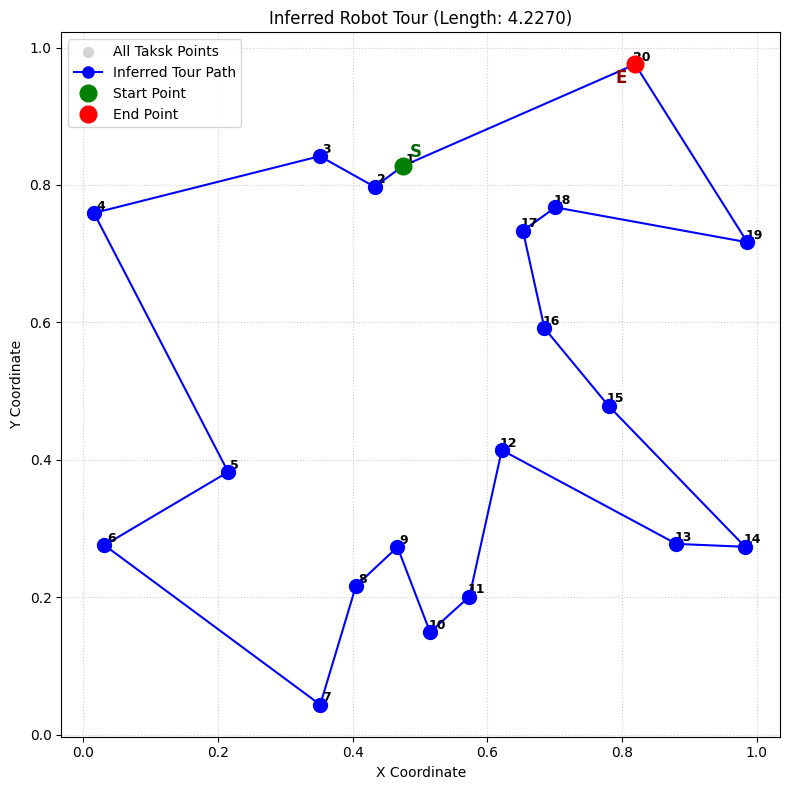

In [72]:

# --- Example Usage ---
if __name__ == '__main__':
    # Define the same hyperparameters used during training
    embedding_dim = 256
    hidden_dim = 256
    seq_len = 20 # Number of tasks

    # Define the path to your saved model
    # Make sure this matches the path used in train_drl_ac
    model_path = 'tsp_ac_256_1L.pth' 

    # Determine device for inference
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Inference will run on: {device}")

    try:
        # 1. Load the Actor model
        loaded_actor = load_actor_model(model_path, embedding_dim, hidden_dim, device)

        # 2. Prepare a single new input instance for inference
        print("\n--- Inferring for a single TSP instance ---")
         
        single_instance_coords = torch.rand(seq_len, 2) # (Seq_len, 2) for one problem
        
        # Convert to float32 if your model was trained with float32 (standard)
        single_instance_coords = single_instance_coords.float()

        # 3. Perform inference
        inferred_tour_indices, inferred_coords_np, tour_length = infer_tour_single_instance(loaded_actor, single_instance_coords)
        
        # print(f"Input coordinates (first 3): \n{single_instance_coords[:3].numpy()}")
        print(f"Inferred tour (indices): {inferred_tour_indices}")
        print(f"Reward for single instance: {tour_length:.4f}")

        # 4. Plot the tour
        plot_tour(single_instance_coords.numpy(), inferred_coords_np, tour_length)

    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}.")
        print("Please ensure you have run the training script and the model file exists.")
    except Exception as e:
        print(f"An unexpected error occurred during inference: {e}")